# Importing Necessary Libraries and Modules

In [1]:
# Standard library imports
import numpy as np
import cv2
from PIL import Image

# Data processing and manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms

# PyTorch neural network components
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax
from torch import flatten

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

In [2]:
X = np.load("./X.npy")
y = np.load("./Y.npy")

In [3]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (22801, 128, 128, 3)
Shape of y: (22801, 1)


In [4]:
num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

Number of classes: 27


In [5]:
classes_names = np.unique(y)
print("Names of classes")

Names of classes


In [6]:
print("Dimensions of a single image:", X[0].shape)

Dimensions of a single image: (128, 128, 3)


# Defining transformations for the images

In [7]:
def preprocess_data(X, y, image_size, mean, stddev):
    """
    Preprocess the image data and labels.
    
    Parameters:
    - X (numpy.ndarray): Array of image data.
    - y (numpy.ndarray): Array of labels.
    - image_size (int): Desired size for resizing images. Default is 32.
    - mean (float): Mean value for normalization. Default is 0.
    - stddev (float): Standard deviation value for normalization. Default is 1.
    
    Returns:
    - X_transformed (torch.Tensor): Transformed image data.
    - y_transformed (torch.Tensor): Encoded labels as a tensor.
    """
    # Ensure X is in float32 format
    X = X.astype(np.float32)
    
    # Define the transformation pipeline
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (stddev,))
    ])
    
    # Apply transformations to each image in X
    X_transformed = torch.stack([transform(image) for image in X])
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y.ravel())
    y_transformed = torch.tensor(y_encoded)
    
    return X_transformed, y_transformed


In [8]:
# Assuming X and y are already defined
image_size=32
mean=0
stddev=1
X_transformed, y_transformed = preprocess_data(X, y, image_size, mean, stddev)

In [9]:
X_transformed.shape, y_transformed.shape

(torch.Size([22801, 3, 32, 32]), torch.Size([22801]))

# Splitting the dataset into train, validation, and test sets


In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Creating DataLoaders for training, validation, and testing

In [11]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the shapes of the datasets

In [13]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: torch.Size([18240, 3, 32, 32])
Shape of y_train: torch.Size([18240])
Shape of X_val: torch.Size([2280, 3, 32, 32])
Shape of y_val: torch.Size([2280])
Shape of X_test: torch.Size([2281, 3, 32, 32])
Shape of y_test: torch.Size([2281])


# Building the CNN Model

In [14]:
def calculate_h_out_w_out(h_in, w_in, kernel_size, out_channels, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):
    """
    Calculate the output dimensions of a convolutional layer.

    Parameters:
    - h_in (int): Input height.
    - w_in (int): Input width.
    - kernel_size (tuple): Size of the convolution kernel (height, width).
    - out_channels (int): Number of output channels (filters).
    - stride (tuple): Stride of the convolution (height_stride, width_stride). Defaults to (1, 1).
    - padding (tuple): Padding applied to the input (height_padding, width_padding). Defaults to (0, 0).
    - dilation (tuple): Dilation rate for the convolution (height_dilation, width_dilation). Defaults to (1, 1).

    Returns:
    - tuple: (h_out, w_out, out_channels) representing the output height, width, and number of channels.
    """
    # Calculate the output height
    h_out = (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) // stride[0] + 1
    
    # Calculate the output width
    w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1] + 1

    # Ensure output dimensions are integers
    assert isinstance(h_out, int), "Output height is not an integer"
    assert isinstance(w_out, int), "Output width is not an integer"
    
    return (h_out, w_out, out_channels)

In [15]:
# Define the CNN class inheriting from nn.Module
class CNN(Module):
    def __init__(self, in_height, in_width, in_channels, num_classes):
        super(CNN, self).__init__()  # Initialize the parent class

        self.in_features = (in_height, in_width, in_channels)  # Store input feature dimensions

        # First convolutional layer: takes input channels and outputs 16 feature maps
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(5, 5), padding=(2, 2))
        self.in_features = calculate_h_out_w_out(in_height, in_width, (5, 5), 16, padding=(2, 2))  # Update dimensions after conv1
        self.relu1 = nn.ReLU()  # ReLU activation after the first convolution
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Max pooling to downsample
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))  # Update dimensions after maxpool1

        # Second convolutional layer: takes 16 input channels and outputs 32 feature maps
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (5, 5), 32)  # Update dimensions after conv2
        self.relu2 = nn.ReLU()  # ReLU activation after the second convolution
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Max pooling to downsample
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))  # Update dimensions after maxpool2

        # Third convolutional layer: takes 32 input channels and outputs 64 feature maps
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (3, 3), 64, padding=(1, 1))  # Update dimensions after conv3
        self.relu3 = nn.ReLU()  # ReLU activation after the third convolution
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # Max pooling to downsample
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))  # Update dimensions after maxpool3

        # Fully connected (linear) layer to connect the flattened output from convolutional layers
        self.fc1 = nn.Linear(in_features=self.in_features[0] * self.in_features[1] * self.in_features[2], out_features=1024)
        self.relu_fc1 = nn.ReLU()  # ReLU activation after the first fully connected layer
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout for regularization

        # Second fully connected layer
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.relu_fc2 = nn.ReLU()  # ReLU activation after the second fully connected layer
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout for regularization

        # Final fully connected layer for classification
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)  # LogSoftmax for classification output

    # Define the forward pass of the network
    def forward(self, x):
        x = self.conv1(x)  # Pass input through first convolutional layer
        x = self.relu1(x)  # Apply ReLU activation
        x = self.maxpool1(x)  # Apply max pooling

        x = self.conv2(x)  # Pass through second convolutional layer
        x = self.relu2(x)  # Apply ReLU activation
        x = self.maxpool2(x)  # Apply max pooling

        x = self.conv3(x)  # Pass through third convolutional layer
        x = self.relu3(x)  # Apply ReLU activation
        x = self.maxpool3(x)  # Apply max pooling

        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers

        x = self.fc1(x)  # Pass through first fully connected layer
        x = self.relu_fc1(x)  # Apply ReLU activation
        x = self.dropout1(x)  # Apply dropout for regularization

        x = self.fc2(x)  # Pass through second fully connected layer
        x = self.relu_fc2(x)  # Apply ReLU activation
        x = self.dropout2(x)  # Apply dropout for regularization

        x = self.fc3(x)  # Pass through the final fully connected layer
        x = self.logSoftmax(x)  # Apply LogSoftmax activation for output

        return x  # Return the final output


# Model Training

In [16]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

In [18]:
def train(model, criterion, optimizer, n_epochs, train_loader, valid_loader, multiclass=False):
    # Initialize lists for traininf and validation loss and accuracy for each epoch
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    # Get the appropriate device
    device = get_device()

    # Iterate over each epoch
    for epoch in range(n_epochs):
        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> TRAINING <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.train()                                # Set the model to training mode
        
        epoch_train_batches_loss = 0.0               # Loss for the current epoch
        epoch_train_correct_predictions = 0          # Number of correct predictions
        epoch_train_total_predictions = 0            # Total number of instances processed

        # Iterate over batches in the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Gradients from the previous batch are zeroed out to prevent accumulation
            optimizer.zero_grad()
            
            # Compute the model output
            outputs = model(inputs)
            
            # Compute the loss based on the criterion passed 
            loss = criterion(outputs.squeeze(), labels)
            
            # Compute the gradients
            loss.backward()
            
            # Update the model parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current batch
            epoch_train_batches_loss += loss.item()

            # Predict
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
            
            # Update the number of correct predictions
            epoch_train_correct_predictions += (predicted.squeeze() == labels).sum().item()
            
            # Update the total number of instances processed
            epoch_train_total_predictions += labels.size(0)

        # Calculate the average loss for the training epoch
        epoch_train_loss = epoch_train_batches_loss / len(train_loader)
        
        # Calculate the accuracy for the training epoch
        epoch_train_accuracy = epoch_train_correct_predictions / epoch_train_total_predictions
        
        # Store the loss and accuracy for training
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> VALIDATION <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.eval()                               # Set the model to evaluation mode
        
        epoch_valid_loss = 0.0                       # Loss for the current validation epoch
        epoch_valid_correct_predictions = 0          # Number of correct predictions
        epoch_valid_total_predictions = 0            # Total number of instances processed
        
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in valid_loader:
                # Move inputs and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the model output
                outputs = model(inputs)
                
                # Compute the loss based on the criterion passed 
                loss = criterion(outputs.squeeze(), labels)
                
                # Accumulate the loss for the current batch
                epoch_valid_loss += loss.item()

                # Predict
                if multiclass:
                    predicted = torch.argmax(outputs, dim=1)
                else:
                    predicted = (outputs > 0.5).float()
                
                # Update the number of correct predictions
                epoch_valid_correct_predictions += (predicted.squeeze() == labels).sum().item()
                
                # Update the total number of instances processed
                epoch_valid_total_predictions += labels.size(0)
        
        # Calculate the average loss and accuracy for the validation epoch
        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy = epoch_valid_correct_predictions / epoch_valid_total_predictions

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)
        
        print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {epoch_train_accuracy:.4f}, "
              f"Val Loss: {epoch_valid_loss:.4f}, Val Accuracy: {epoch_valid_accuracy:.4f}")

    # Return the losses and accuracies over all epochs
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [19]:
image_height = image_size
image_width = image_size
n_channels = X.shape[3]
print(image_height, image_width, n_channels)
n_classes = len(np.unique(y))

32 32 3


In [20]:
model = CNN(in_height=image_height, in_width=image_width, in_channels=n_channels, num_classes=n_classes)
model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=1024, bias=True)
  (relu_fc1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu_fc2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=27, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [21]:
count_parameters(model)

Layer: conv1, Parameters: 1216
Layer: relu1, Parameters: 0
Layer: maxpool1, Parameters: 0
Layer: conv2, Parameters: 12832
Layer: relu2, Parameters: 0
Layer: maxpool2, Parameters: 0
Layer: conv3, Parameters: 18496
Layer: relu3, Parameters: 0
Layer: maxpool3, Parameters: 0
Layer: fc1, Parameters: 590848
Layer: relu_fc1, Parameters: 0
Layer: dropout1, Parameters: 0
Layer: fc2, Parameters: 524800
Layer: relu_fc2, Parameters: 0
Layer: dropout2, Parameters: 0
Layer: fc3, Parameters: 13851
Layer: logSoftmax, Parameters: 0


1162043

In [22]:
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [23]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, criterion, optimizer, n_epochs, train_loader, val_loader, True)


Epoch [1/20], Train Loss: 3.0339, Train Accuracy: 0.1057, Val Loss: 2.3263, Val Accuracy: 0.2671
Epoch [2/20], Train Loss: 1.9877, Train Accuracy: 0.3685, Val Loss: 1.6438, Val Accuracy: 0.4645
Epoch [3/20], Train Loss: 1.4552, Train Accuracy: 0.5225, Val Loss: 1.2860, Val Accuracy: 0.5776
Epoch [4/20], Train Loss: 1.1841, Train Accuracy: 0.6145, Val Loss: 0.9841, Val Accuracy: 0.6842
Epoch [5/20], Train Loss: 0.9911, Train Accuracy: 0.6754, Val Loss: 0.8921, Val Accuracy: 0.7070
Epoch [6/20], Train Loss: 0.8439, Train Accuracy: 0.7228, Val Loss: 0.7574, Val Accuracy: 0.7566
Epoch [7/20], Train Loss: 0.7370, Train Accuracy: 0.7611, Val Loss: 0.7671, Val Accuracy: 0.7680
Epoch [8/20], Train Loss: 0.6670, Train Accuracy: 0.7832, Val Loss: 0.6824, Val Accuracy: 0.7868
Epoch [9/20], Train Loss: 0.5797, Train Accuracy: 0.8123, Val Loss: 0.5997, Val Accuracy: 0.8092
Epoch [10/20], Train Loss: 0.5293, Train Accuracy: 0.8249, Val Loss: 0.6760, Val Accuracy: 0.7996
Epoch [11/20], Train Loss: 0.

# Training Metrics Visualization

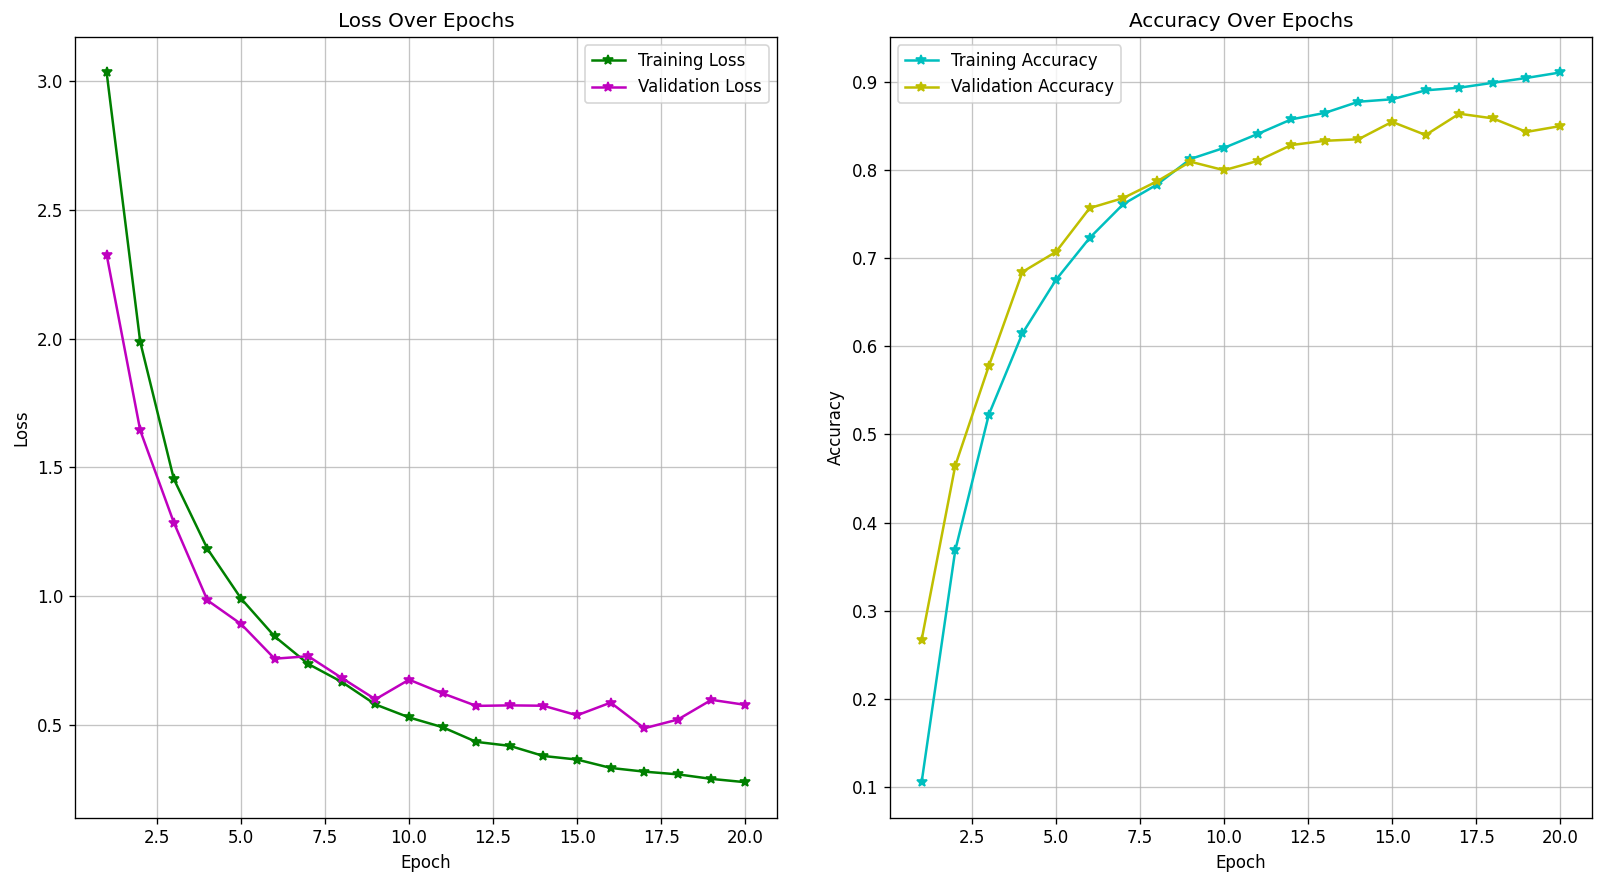

In [24]:
def visualize_training_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies):
    fig_size = (14, 8)
    plot_resolution = 120
    grid_alpha = 0.75

    epoch_numbers = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=fig_size, dpi=plot_resolution)
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epoch_numbers, train_losses, 'g*-', label='Training Loss')
    plt.plot(epoch_numbers, valid_losses, 'm*-', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True, alpha=grid_alpha)
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epoch_numbers, train_accuracies, 'c*-', label='Training Accuracy')
    plt.plot(epoch_numbers, valid_accuracies, 'y*-', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True, alpha=grid_alpha)
    
    plt.tight_layout(pad=3.0)
    plt.show()

# Pozivanje funkcije sa podacima
visualize_training_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies)


# Evaluation Process

In [25]:
def evaluate(model, criterion, loader, multiclass=False):
    # Set the model to evaluation mode
    model.eval()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    predicted_labels, true_labels = [], []
    
    # Get the device
    device = get_device()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(inputs)
            
            # Compute loss
            total_loss += criterion(outputs.squeeze(), labels).item()

            # Predict class labels
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
                
            # Append predictions and true labels for metric computation
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            # Update total samples and correct predictions count
            total_samples += labels.size(0)
            total_correct += (predicted.squeeze() == labels).sum().item()

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    
    # Print evaluation results
    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d',  xticklabels=classes_names,  yticklabels=classes_names)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # Average loss over all batches
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x00000222E8841610>
Accuracy: 0.8496
Precision: 0.8535
Recall: 0.8496
F1 Score: 0.8491


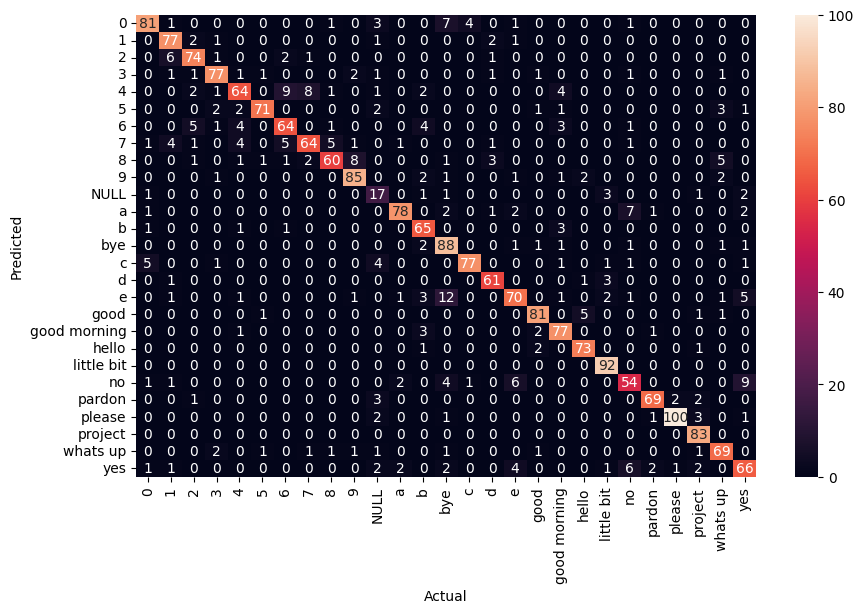

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x00000222E89A13A0>
Accuracy: 0.8566
Precision: 0.8610
Recall: 0.8566
F1 Score: 0.8559


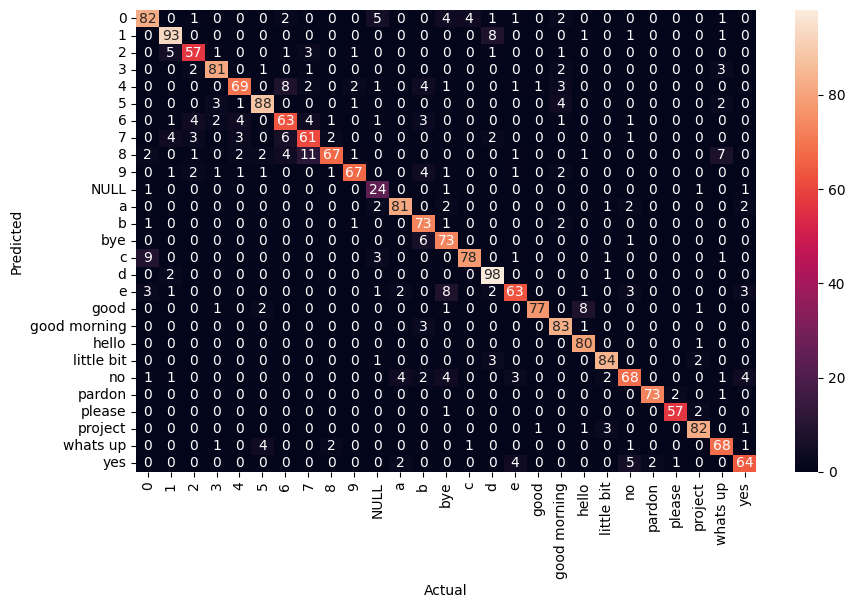

In [26]:
# Evaluate on validation and test sets
print("="*150)
valid_loss, val_accuracy = evaluate(model, criterion, val_loader, multiclass=True)
print("="*150)
test_loss, test_accuracy = evaluate(model, criterion, test_loader, multiclass=True)

In [27]:
torch.save(model.state_dict(), 'model2.pth')